In [1]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
# from efficientnet_pytorch import EfficientNet


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PRIVATE_PATH_NEW = INPUT_PATH / 'idao_dataset' / 'private_test_new'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
class Config:
    BATCH_SIZE = 32
    TRAINING_EPOCHS = 150
    VALIDATION_STEPS_PER_EPOCH = 5
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 5
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [3]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 0 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 1 # HE
        particle_energy = int(img_path.split('_')[8])
    return [img_path, particle_class, particle_energy]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy']

In [4]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)
er_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)

In [5]:
# TODO: Write this to a separate folder

# 0 - [:750]
# 1 - [750:1502]
# 0 - [1502:7531]
# 1 - [7531:]

import glob
private_test = glob.glob(str(PRIVATE_PATH / '**/*.png'), recursive=True)
public_test = glob.glob(str(PUBLIC_PATH / '**/*.png'), recursive=True)

sample_submission = pd.read_csv(INPUT_PATH / 'track1_predictions_example.csv')
private_ids = [t.split('/')[-1].split('.')[0] for t in private_test]
public_ids = [t.split('/')[-1].split('.')[0] for t in public_test]

# sample_submission['path'] = sample_submission['id'].apply(lambda x: PRIVATE_PATH / f'{x}.png' if x in private_ids else PUBLIC_PATH / f'{x}.png').map(str)
# sample_submission.iloc[:750, 1] = 0
# sample_submission.iloc[750:1502, 1] = 1
# sample_submission.iloc[1502:7531, 1] = 0
# sample_submission.iloc[7531:, 1] = 1

# sample_submission = sample_submission.iloc[1502:].reset_index(drop = True)

# images_leak = pd.DataFrame(np.array([sample_submission.iloc[:, 3].values, sample_submission.iloc[:, 1].values, sample_submission.iloc[:, 2].values]).T)
# images_leak.columns = ['path', 'class', 'energy']

In [6]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]
images = images.drop(index = test_idx)


train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
train_images = train_images.reset_index(drop = True)
valid_images = valid_images.reset_index(drop = True)

In [7]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X_1 = np.zeros((self.batch_size, 150, 150, 3))
        X_2 = np.zeros((self.batch_size, 150, 150, 3))
        y_energy_similarity = np.zeros((self.batch_size))
        y_class_similarity = np.zeros((self.batch_size))
        for i, idx in enumerate(batch):
            idx_2 = np.random.choice(batch)
            image_1 = cv2.imread(self.images.iloc[idx, 0])[225:375, 225:375, :]
            image_2 = cv2.imread(self.images.iloc[idx_2, 0])[225:375, 225:375, :]
            X_1[i,] = image_1
            X_2[i,] = image_2
            
            if self.augment:
                X_1[i, ] = Config.train_transform(image=X_1[i,].astype(np.uint8))['image']
                X_2[i, ] = Config.train_transform(image=X_2[i,].astype(np.uint8))['image']
            particle_energy_1 = self.images.iloc[idx, 2]
            particle_energy_2 = self.images.iloc[idx_2, 2]
    
            y_energy_similarity[i] = 1 if (particle_energy_1 == particle_energy_2) else 0
        
            particle_class_1 = self.images.iloc[idx, 1]
            particle_class_2 = self.images.iloc[idx_2, 1]
            
            y_class_similarity[i] = 1 if (particle_class_1 == particle_class_2) else 0
        
        return (X_1 / 255.0, X_2 / 255.0), y_energy_similarity


In [9]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, augment = False)
valid_datagen = DataGenerator(valid_images, batch_size = Config.BATCH_SIZE)
test_datagen = DataGenerator(test_images, batch_size = 1, shuffle = False)

In [10]:
# Example data extract

(X_1, X_2), y_energy_similarity = train_datagen.__getitem__(0)

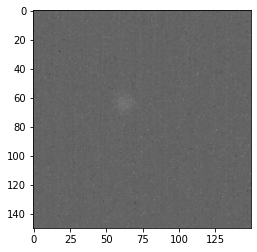

In [12]:
idx = 17
plt.imshow((X_1[idx] * 255).astype(np.uint8))


## Class model

In [201]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model_1 = ResNet152V2(weights='imagenet', include_top=False)
base_model_2 = ResNet152V2(weights='imagenet', include_top=False)

In [18]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow.keras
import tensorflow

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / 'cnn_classification_best', save_best_only=True, monitor='val_auc', mode='max')

# siamise network
def conv_block():
    # Sequence of two convolutional and pooling layers as feature extractors
    
    inp = L.Input(shape=(150,150,3))
    x = L.Conv2D(16, kernel_size=2, activation='relu')(inp)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(16, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = L.Conv2D(64, kernel_size=4, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, kernel_size=4, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    out = L.GlobalAveragePooling2D()(x)
    
    return Model(inputs=[inp], outputs=[out])

def create_regression_model():
    
    conv = conv_block()
    
    inp_1 = L.Input(shape=(150,150,3))
    inp_2 = L.Input(shape=(150,150,3))
    
    out_1 = conv(inp_1)
    out_2 = conv(inp_2)
    
    #############
    # OUTPUT 
    ############
    
    # Getting the L1 Distance between the 2 encodings
    L1_layer = L.Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

    # Add the distance function to the network
    L1_distance = L1_layer([out_1, out_2])
#     x = L.Dense(128, activation='relu')(x)
    
    predictions_similarity = L.Dense(1, activation='sigmoid', name='similarity')(L1_distance)

    # this is the model we will train
    model = Model(inputs=[inp_1, inp_2], outputs=[predictions_similarity])


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss={
                      'similarity':'binary_crossentropy', 
                  },
                  metrics = {
                             'similarity': 'AUC', 
                  })
    return model

In [19]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / 'cnn_classification_best', save_best_only=True, monitor='val_auc', mode='max')

# generic network
def create_regression_model(base_model_1, base_model_2):
    
    for layer in base_model_1.layers:
        layer._name = layer.name + str("_1")
    
    for layer in base_model_2.layers:
        layer._name = layer.name + str("_2")
    
    
    ###############
    # BRANCH 1
    ###############
    
    for layer in base_model_1.layers[:-5]:
        layer.trainable = False
        
    x1 = base_model_1.output
    x1 = L.GlobalAveragePooling2D()(x1)
    
    ###############
    # BRANCH 2
    ###############
    
    for layer in base_model_2.layers[:-5]:
        layer.trainable = False
        
    x2 = base_model_2.output
    x2 = L.GlobalAveragePooling2D()(x2)
    
    
    #############
    # OUTPUT 
    ############
    
    x = L.Concatenate(axis=1)([x1, x2])
    x = L.Dense(512, activation='relu')(x)
    x = L.Dense(64, activation='relu')(x)
    
    predictions_similarity = L.Dense(1, activation='sigmoid', name='similarity')(x)

    # this is the model we will train
    model = Model(inputs=[base_model_1.input, base_model_2.input], outputs=[predictions_similarity])


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss={
                      'similarity':'binary_crossentropy', 
                  },
                  metrics = {
                             'similarity': 'AUC',
                  })
    return model

In [20]:
model = create_regression_model()

In [22]:
model.fit(
    train_datagen, 
    steps_per_epoch = Config.STEPS_PER_EPOCH, 
    validation_data = valid_datagen, 
    validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
    epochs = Config.TRAINING_EPOCHS,
    verbose = 1,
    callbacks = [earlystop]
    )

Epoch 1/150
30/30 [==============================] - 12s 285ms/step - loss: 0.5506 - auc: 0.7851 - val_loss: 0.6924 - val_auc: 0.5000
Epoch 2/150
30/30 [==============================] - 8s 266ms/step - loss: 0.4516 - auc: 0.8313 - val_loss: 0.6923 - val_auc: 0.5000
Epoch 3/150
30/30 [==============================] - 8s 282ms/step - loss: 0.4292 - auc: 0.8465 - val_loss: 0.6910 - val_auc: 0.5000
Epoch 4/150
30/30 [==============================] - 9s 285ms/step - loss: 0.3973 - auc: 0.8806 - val_loss: 0.6877 - val_auc: 0.7424
Epoch 5/150
30/30 [==============================] - 8s 271ms/step - loss: 0.3683 - auc: 0.8841 - val_loss: 0.6765 - val_auc: 0.7711
Epoch 6/150
30/30 [==============================] - 9s 287ms/step - loss: 0.3707 - auc: 0.8950 - val_loss: 0.6423 - val_auc: 0.8080
Epoch 7/150
30/30 [==============================] - 9s 285ms/step - loss: 0.3658 - auc: 0.8827 - val_loss: 0.5856 - val_auc: 0.7726
Epoch 8/150
30/30 [==============================] - 8s 276ms/step -

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model(OUTPUT_PATH / 'models' / 'cnn_classification_best')

In [23]:
model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)

51/51 [==============================] - 11s 218ms/step - loss: 0.3080 - auc: 0.9636


[0.3079576790332794, 0.9635542035102844]

In [24]:
model.evaluate(test_datagen, batch_size=1, steps=test_images.shape[0])

12/12 [==============================] - 0s 8ms/step - loss: 0.7022 - auc: 0.0000e+00


[0.7022247314453125, 0.0]

In [25]:
path = valid_images[valid_images['energy'] == 10]['path'].iloc[0]
img_1_0 = cv2.imread(path)[225:375, 225:375, :].reshape(1,150,150,3) / 255.0

path = valid_images[valid_images['energy'] == 1]['path'].iloc[1]
img_1_1 = cv2.imread(path)[225:375, 225:375, :].reshape(1,150,150,3) / 255.0

20 [[0.09018934]]
1 [[0.29812217]]
20 [[0.13178027]]
1 [[0.26040158]]
6 [[0.40446424]]
1 [[0.21543126]]
10 [[0.4301974]]
3 [[0.43405816]]
30 [[0.09355532]]
30 [[0.04542581]]
3 [[0.29587677]]
10 [[0.35974213]]


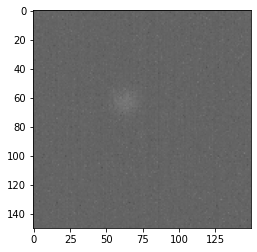

In [26]:
for path in glob.glob(str(PRIVATE_PATH_NEW / '*.png'))[20:21]:
    for i in range(12):
        img_known = cv2.imread(test_images['path'].iloc[i])[225:375, 225:375, :].reshape(1,150,150,3)  / 255.0
        img_unknown = cv2.imread(path)[225:375, 225:375, :].reshape(1,150,150,3)  / 255.0
        print(test_images['energy'].iloc[i], model.predict([img_known, img_unknown]))
    plt.imshow(img_unknown[0])
    break

In [211]:
for i in range(12):
    img_2 = cv2.imread(test_images['path'].iloc[i])[225:375, 225:375, :].reshape(1,150,150,3)  / 255.0
    print(test_images['energy'].iloc[i])
    print(model.predict([img_1_0, img_2]))

20
[[0.001827]]
1
[[0.00122305]]
20
[[0.02869981]]
1
[[0.00067241]]
6
[[0.43552744]]
1
[[0.00328127]]
10
[[0.23529464]]
3
[[0.00154513]]
30
[[0.18697701]]
30
[[0.14862026]]
3
[[0.01151415]]
10
[[0.5718494]]


In [29]:
idx = 2
for i in range(12):
    if (i != idx):
        img_1 = cv2.imread(test_images['path'].iloc[idx])[225:375, 225:375, :].reshape(1,150,150,3) / 255.0
        img_2 = cv2.imread(test_images['path'].iloc[i])[225:375, 225:375, :].reshape(1,150,150,3)  / 255.0

        print(test_images['energy'].iloc[idx], test_images['energy'].iloc[i])
        print(model.predict([img_1, img_2]))

20 20
[[0.28409746]]
20 1
[[0.0634098]]
20 1
[[0.0519391]]
20 6
[[0.22311096]]
20 1
[[0.05591356]]
20 10
[[0.1934719]]
20 3
[[0.11978564]]
20 30
[[0.43680453]]
20 30
[[0.2634144]]
20 3
[[0.06141673]]
20 10
[[0.21704404]]


In [69]:
model.predict([img_1, img_2])

array([[0.43658105]], dtype=float32)

In [190]:
#valid_datagen = DataGenerator(valid_images, batch_size = 1, is_classification = False, shuffle = False)
y_pred = model.predict_generator(test_datagen)

In [194]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_images['class'].values, y_pred[0].reshape(-1))

0.6388888888888888

In [195]:
y_pred[1]

array([[5.7954117e-07, 1.9888972e-01, 8.0110973e-01],
       [7.3485440e-01, 2.6513726e-01, 8.3158848e-06],
       [3.9333791e-23, 6.7309658e-16, 1.0000000e+00],
       [6.5505534e-02, 9.3448120e-01, 1.3233274e-05],
       [2.1247061e-01, 7.8709042e-01, 4.3904246e-04],
       [8.1784785e-01, 1.8214710e-01, 5.0222520e-06],
       [6.0002959e-01, 3.9994812e-01, 2.2300765e-05],
       [1.7441712e-12, 1.8200633e-07, 9.9999976e-01],
       [8.4439290e-01, 1.5516184e-01, 4.4518636e-04],
       [5.8094036e-02, 9.4188356e-01, 2.2422120e-05],
       [3.7690727e-13, 3.0495130e-05, 9.9996948e-01],
       [4.7013474e-01, 4.7852191e-01, 5.1343340e-02]], dtype=float32)

In [173]:
y_pred

array([[2.4027457e-03, 9.7355902e-01, 7.5503761e-01],
       [9.9316108e-01, 9.1888613e-01, 1.9390632e-03],
       [5.1112971e-07, 1.4816903e-01, 9.9999678e-01],
       [9.6381307e-01, 9.6892124e-01, 1.9251545e-03],
       [9.6767712e-01, 8.5400051e-01, 8.5106995e-03],
       [9.9878114e-01, 9.1105253e-01, 5.7318324e-04],
       [9.9665135e-01, 9.1981822e-01, 1.0628236e-03],
       [1.5396510e-07, 6.2851411e-01, 9.9998522e-01],
       [9.7442836e-01, 8.7898016e-01, 9.2895711e-03],
       [9.5169121e-01, 9.6847647e-01, 2.6327744e-03],
       [5.4199674e-08, 9.6421957e-01, 9.9990618e-01],
       [8.2514286e-01, 3.5728958e-01, 3.2684523e-01]], dtype=float32)

In [163]:
np.argmax(y_pred, axis = 1)

array([1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0])

In [64]:
test_images

,path,class,energy
728,../input/idao_dataset/train/ER/0.5620372891426...,0,20
2518,../input/idao_dataset/train/ER/2.2105474472045...,0,1
3760,../input/idao_dataset/train/ER/-0.482575029134...,0,20
4922,../input/idao_dataset/train/ER/0.5805498957633...,0,1
5424,../input/idao_dataset/train/ER/1.1956702470779...,0,6
6487,../input/idao_dataset/train/ER/0.4857539832592...,0,1
9472,../input/idao_dataset/train/NR/-1.353199958801...,1,3
9593,../input/idao_dataset/train/NR/-2.992399930953...,1,30
10201,../input/idao_dataset/train/NR/2.4159998893737...,1,10
11008,../input/idao_dataset/train/NR/1.4197000265121...,1,3


In [59]:
y_pred_changed = y_pred.copy()
y_pred_changed[test_images['class'] == 0, 0] = np.array([1,6,20])[np.argmin(np.abs(y_pred_changed[test_images['class'] == 0] - [1,6,20]), axis = 1)]
y_pred_changed[test_images['class'] == 1, 0] = np.array([3,10,30])[np.argmin(np.abs(y_pred_changed[test_images['class'] == 1] - [3,10,30]), axis = 1)]
y_pred_changed = y_pred_changed.reshape(-1)

In [61]:
mean_absolute_error(test_images['energy'], y_pred_changed)

3.9166666666666665

In [51]:
model.save(OUTPUT_PATH / 'models' / 'cnn_classification')